In [1]:
from torch_geometric.data import HeteroData
from torch_geometric.datasets import Entities
from torch_geometric.transforms.random_node_split import RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GraphConv, to_hetero
import torch.nn.functional as F
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = torch.load('data/hetero_data.pt')
data = T.ToUndirected()(data)
data = T.NormalizeFeatures()(data)
split = RandomNodeSplit(num_test=0.33, num_val=0.2)

data = split(data)

In [36]:
hidden_layer_sizes = [16, 32, 64, 128, 256]

In [26]:
EPOCHS = 650

In [30]:
def train(model, data, optimizer, n_epochs=200):
    train_accs = []
    val_accs = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        mask = data['incident'].train_mask
        loss_fn = F.cross_entropy(out['incident'][mask], data['incident'].y[mask].type(torch.LongTensor))
        loss_fn.backward(retain_graph=True)
        optimizer.step()

        val_acc = evaluate(model, data, data['incident'].val_mask, test_flag=False)
        train_acc = (out['incident'][mask].argmax(dim=-1) == data['incident'].y[mask]).sum()/float(mask.sum())
        if epoch == n_epochs // 2  or epoch == n_epochs:
            print(f'\tEpoch: {epoch}, train_acc: {train_acc:.5f}, val_acc: {val_acc:.5f}')

        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_accs, val_accs


def evaluate(model, data, mask, test_flag):
    with torch.no_grad():
        model.eval()
        out = model(data.x_dict, data.edge_index_dict)['incident']
        pred = out.argmax(dim=-1)
        correct = (pred[mask] == data['incident'].y[mask]).sum()

        acc_score = correct/float(mask.sum())
        
        if test_flag:
            return acc_score, metrics.confusion_matrix(y_pred=pred[mask], y_true=data['incident'].y[mask])

        return acc_score

## 1 konvolutivni sloj

In [31]:
class SingleLayerGCN(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv = SAGEConv((-1, -1), out_channels, aggr='mean')

    def forward(self, x, edge_index):
        x = F.softmax(self.conv(x, edge_index), dim=1)

        return x


gcn = SingleLayerGCN(out_channels=2)
gcn = to_hetero(gcn, data.metadata(), aggr='sum')
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001, weight_decay=5e-4)

In [32]:
train_accuracies, val_accuracies = train(gcn, data, optimizer, EPOCHS)

 50%|████████████████████████████████████████                                        | 325/650 [02:15<02:12,  2.45it/s]

	Epoch: 325, train_acc: 0.54262, val_acc: 0.53883


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [04:29<00:00,  2.41it/s]

	Epoch: 650, train_acc: 0.55152, val_acc: 0.54882


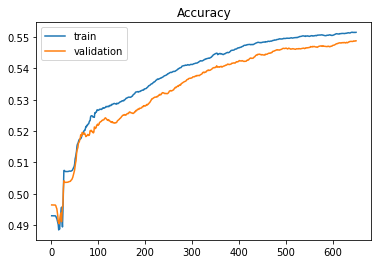

In [45]:
plt.title('Accuracy')
plt.plot(np.arange(1, EPOCHS+1), train_accuracies, label='train')
plt.plot(np.arange(1, EPOCHS+1), val_accuracies, label='validation')
plt.legend()
plt.show()

## 2 konvolutivna sloja

In [41]:
class TwoLayerGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels, aggr='mean')
        self.conv2 = SAGEConv((-1, -1), out_channels, aggr='mean')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.softmax(self.conv2(x, edge_index), dim=1)

        return x

In [42]:
train_accuracies2, val_accuracies2 = ([], [])
trained_models2 = []

for hidden_channels in hidden_layer_sizes:
    gcn2 = TwoLayerGCN(hidden_channels=hidden_channels, out_channels=2)
    gcn2 = to_hetero(gcn2, data.metadata(), aggr='sum')
    optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.001, weight_decay=5e-4)
    
    print(f'Training model with hidden channel size of {hidden_channels}')
    train_accs, val_accs = train(gcn2, data, optimizer, EPOCHS)
    print()
    trained_models2.append([gcn2, hidden_channels])
    train_accuracies2.append(train_accs)
    val_accuracies2.append(val_accs)

  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

Training model with hidden channel size of 16


 50%|████████████████████████████████████████                                        | 325/650 [08:17<08:13,  1.52s/it]

	Epoch: 325, train_acc: 0.56739, val_acc: 0.56332


  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

	Epoch: 650, train_acc: 0.60367, val_acc: 0.60351

Training model with hidden channel size of 32


 50%|████████████████████████████████████████                                        | 325/650 [13:50<13:58,  2.58s/it]

	Epoch: 325, train_acc: 0.58118, val_acc: 0.57800


  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

	Epoch: 650, train_acc: 0.61068, val_acc: 0.60866

Training model with hidden channel size of 64


 50%|████████████████████████████████████████                                        | 325/650 [11:34<11:14,  2.07s/it]

	Epoch: 325, train_acc: 0.58931, val_acc: 0.58763


  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

	Epoch: 650, train_acc: 0.62089, val_acc: 0.62009

Training model with hidden channel size of 128


 50%|████████████████████████████████████████                                        | 325/650 [20:53<21:22,  3.95s/it]

	Epoch: 325, train_acc: 0.60592, val_acc: 0.60255


  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

	Epoch: 650, train_acc: 0.64224, val_acc: 0.63756

Training model with hidden channel size of 256


 50%|████████████████████████████████████████                                        | 325/650 [37:03<37:01,  6.83s/it]

	Epoch: 325, train_acc: 0.59916, val_acc: 0.59832


100%|██████████████████████████████████████████████████████████████████████████████| 650/650 [1:15:19<00:00,  6.95s/it]

	Epoch: 650, train_acc: 0.63071, val_acc: 0.62842



### Dopuna

In [48]:
hidden_layer_sizes.append(512)

In [49]:
gcn2 = TwoLayerGCN(hidden_channels=512, out_channels=2)
gcn2 = to_hetero(gcn2, data.metadata(), aggr='sum')
optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.001, weight_decay=5e-4)

print(f'Training model with hidden channel size of 512')
train_accs, val_accs = train(gcn2, data, optimizer, EPOCHS)
print()
trained_models2.append([gcn2, 512])
train_accuracies2.append(train_accs)
val_accuracies2.append(val_accs)

  0%|                                                                                          | 0/650 [00:00<?, ?it/s]

Training model with hidden channel size of 512


 50%|██████████████████████████████████████                                      | 325/650 [1:09:48<1:08:14, 12.60s/it]

	Epoch: 325, train_acc: 0.60580, val_acc: 0.60312


100%|██████████████████████████████████████████████████████████████████████████████| 650/650 [2:19:48<00:00, 12.91s/it]

	Epoch: 650, train_acc: 0.64593, val_acc: 0.64726



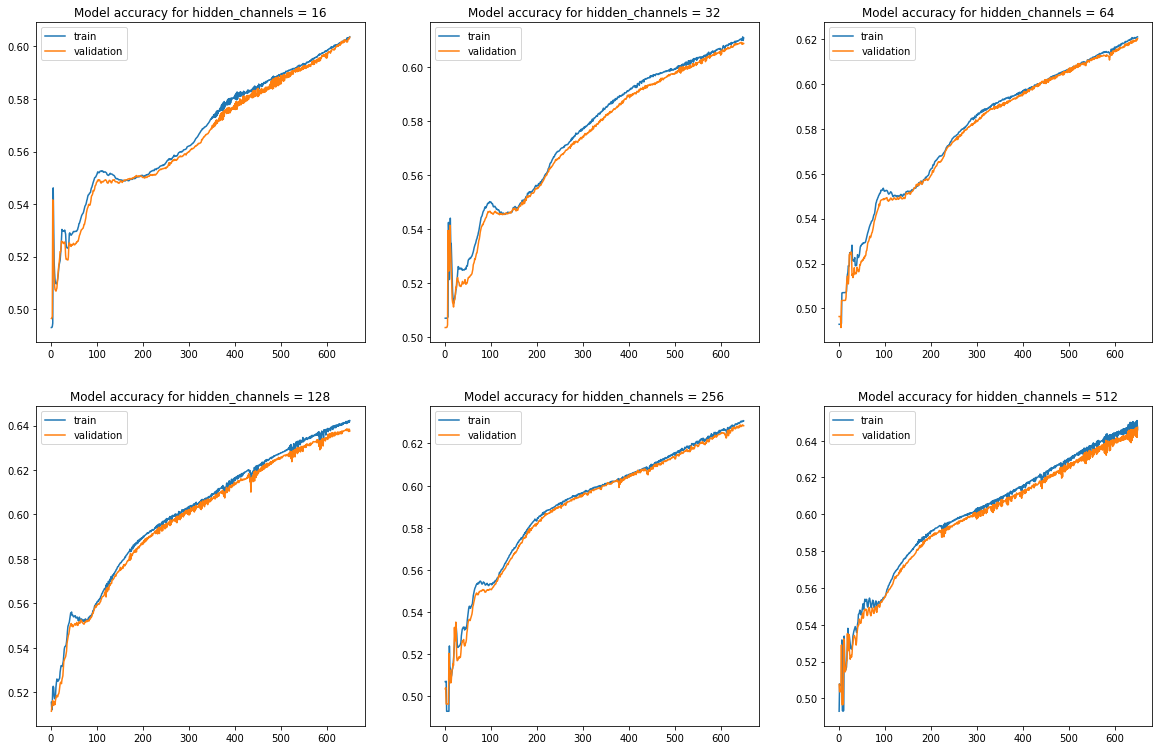

In [50]:
from random import randint

fig = plt.figure(figsize=(20, 20))
for i in range(len(hidden_layer_sizes)):
    plt.subplot(3, 3, i+1)
    plt.title(f'Model accuracy for hidden_channels = {hidden_layer_sizes[i]}')
    plt.plot(np.arange(1, EPOCHS+1), train_accuracies2[i], label='train')
    plt.plot(np.arange(1, EPOCHS+1), val_accuracies2[i], label='validation')
    plt.legend()

## 3 konvolutivna sloja

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels[0], aggr='mean')
        self.conv2 = SAGEConv((-1, -1), hidden_channels[1], aggr='mean')
        self.conv3 = SAGEConv((-1, -1), out_channels, aggr='mean')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.softmax(self.conv3(x, edge_index), dim=1)

        return x

In [ ]:
train_accuracies3, val_accuracies3 = ([], [])
trained_models3 = []

for i in range(len(hidden_layer_sizes) - 1)
    gcn3 = GCN(hidden_channels=[hidden_layer_sizes[i+1], hidden_layer_sizes[i]], out_channels=2)
    gcn3 = to_hetero(gcn3, data.metadata(), aggr='sum')
    optimizer = torch.optim.Adam(gcn3.parameters(), lr=0.001, weight_decay=5e-4)
    
    print(f'Training model with hidden channel sizes of [{hidden_layer_sizes[i+1]}, {hidden_layer_sizes[i]}]')
    train_accs, val_accs = train(gcn3, data, optimizer, EPOCHS)
    print()
    trained_models3.append([gcn3, hidden_layer_sizes[i+1], hidden_layer_sizes[i]])
    train_accuracies3.append(train_accs)
    val_accuracies3.append(val_accs)

In [ ]:
from random import randint

fig = plt.figure(figsize=(20, 20))
for i in range(len(hidden_layer_sizes)-1):
    plt.subplot(3, 3, i+1)
    plt.title(f'Model accuracy for hidden_channels = [{hidden_layer_sizes[i+1]}, {hidden_layer_sizes[i]}]')
    plt.plot(np.arange(1, EPOCHS+1), train_accuracies3[i], label='train')
    plt.plot(np.arange(1, EPOCHS+1), val_accuracies3[i], label='validation')